In [10]:
# importing libraries

import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import numpy as np

Some data sets have unequal length series. Two data sets with this characteristic are shipped with sktime: PLAID (univariate) and JapaneseVowels (multivariate). We cannot store unequal length series in numpy arrays. Instead, we use a nested pandas.DataFrame, where each cell is a pandas.Series. This is the default return type for all single problem loaders.

In [11]:
# general parameters

len_series = 2000  # the leght max of the time series

In [12]:
# Create Nasa Dataframe

#import dataset
list_cells= ['B0005','B0006','B0007','B0018','B0025','B0026','B0027','B0028']
nasa_dataset={}
for cell in list_cells:
    cell_dataset = scipy.io.loadmat('/home/apetrella/Workspace/battery_tsc/dataset/Nasa/5. Battery Data Set/DS/'+ cell +'.mat', simplify_cells=True)
    del cell_dataset["__header__"]
    del cell_dataset["__version__"]
    del cell_dataset["__globals__"]
    
    nasa_dataset[cell] = cell_dataset[cell]


# divide the dataset in 3 parts: charge, discharge and impedance
# in this work, we used only the charge part
 
nasa_dict={}

# for each cell
for cell in list_cells:
    nasa_dict[cell]={}
    nasa_dict[cell]['charge'] = []
    nasa_dict[cell]['discharge'] = []
    nasa_dict[cell]['impedance'] = []

    # save into the right part of dict
    for key in range(len(nasa_dataset[cell]['cycle'])):
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'charge' and key > 1 ):   # non cago il primo di ogni cella che vaneggia...
            nasa_dict[cell]['charge'].append(nasa_dataset[cell]['cycle'][key]['data'])

        if (nasa_dataset[cell]['cycle'][key]['type'] == 'discharge' ):
            nasa_dict[cell]['discharge'].append(nasa_dataset[cell]['cycle'][key]['data'])
        
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'impedance' ):
            nasa_dict[cell]['impedance'].append(nasa_dataset[cell]['cycle'][key]['data'])

    
    # to calculate the SoH, we need to know the capacity. we save the capacity information from discharge to charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        
        if (k < len(nasa_dict[cell]['discharge'])):
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['discharge'][k]['Capacity']
        else:
            # per ora ricopio l'ultimo letto
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['charge'][k-1]['SoH']


    #from capacity to SoH
    # the first one is 100, and the other ones are calculated
    start_Ah= 0
    for k,v in enumerate(nasa_dict[cell]['charge']):
        if (k == 0):
            start_Ah = nasa_dict[cell]['charge'][k]['SoH'] 
            nasa_dict[cell]['charge'][k]['SoH'] = 100
        else:
            nasa_dict[cell]['charge'][k]['SoH'] = int(round(nasa_dict[cell]['charge'][k]['SoH'] / start_Ah * 100))


    #convert array in panda series, it is nedded to use sktime.



    serie_vuota = []
    for i in range(len_series):
        serie_vuota.append(0.0)

    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict[cell]['charge'][k]['Voltage_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_measured'][:len_series])
        #nasa_dict[cell]['charge'][k]['Current_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Current_measured'][:len_series])
        nasa_dict[cell]['charge'][k]['Temperature_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Temperature_measured'][:len_series])
        #nasa_dict[cell]['charge'][k]['q'] = pd.Series(serie_vuota)
        #nasa_dict[cell]['charge'][k]['Current_charge'] = pd.Series(nasa_dict[cell]['charge'][k]['Current_charge'][:len_series])
        #nasa_dict[cell]['charge'][k]['Voltage_charge'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_charge'][:len_series])
        #nasa_dict[cell]['charge'][k]['Time'] = pd.Series(nasa_dict[cell]['charge'][k]['Time'][:len_series])

# prima di unire, metto 'B0018' e 'B0028' nel test 
# copio nasa dict, poi rimuovo da entrambi le celle da non usare, rispettivamente
# ['B0005','B0006','B0007','B0018','B0025','B0026','B0027','B0028']       
nasa_dict_test = nasa_dict.copy() 

del nasa_dict_test['B0005']
del nasa_dict_test['B0006']
del nasa_dict_test['B0007']
del nasa_dict_test['B0025']
del nasa_dict_test['B0026']
del nasa_dict_test['B0027']
del nasa_dict['B0018']
del nasa_dict['B0028']




# unify, the dataset, as a unique battery/cell
# TRAIN
nasa_dict_unify={}
nasa_dict_unify['charge'] = []
#nasa_dict_unify['discharge'] = []
#nasa_dict_unify['impedance'] = []

for cell in ['B0005','B0006','B0007','B0025','B0026','B0027'] :
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict_unify['charge'].append(v)
    # unisco charge
    # for k,v in enumerate(nasa_dict[cell]['discharge']):
    #     nasa_dict_unify['discharge'].append(v)
    # # unisco charge
    # for k,v in enumerate(nasa_dict[cell]['impedance']):
    #     nasa_dict_unify['impedance'].append(v)

#print(nasa_dict_unify['charge'])

df_nasa= pd.DataFrame.from_dict(nasa_dict_unify['charge'])

#rimuovo dati "non interessanti"(che non voglio usare)
df_nasa=df_nasa.drop("Current_charge",axis=1)
df_nasa=df_nasa.drop("Voltage_charge",axis=1)
df_nasa=df_nasa.drop("Time",axis=1)
#df_nasa=df_nasa.drop("q",axis=1)
df_nasa=df_nasa.drop("Current_measured",axis=1)


# ripeto per test
nasa_dict_test_unify={}
nasa_dict_test_unify['charge'] = []
#nasa_dict_unify['discharge'] = []
#nasa_dict_unify['impedance'] = []

for cell in ['B0018','B0028'] :
    # unisco charge
    for k,v in enumerate(nasa_dict_test[cell]['charge']):
        nasa_dict_test_unify['charge'].append(v)
    # unisco charge
    # for k,v in enumerate(nasa_dict[cell]['discharge']):
    #     nasa_dict_unify['discharge'].append(v)
    # # unisco charge
    # for k,v in enumerate(nasa_dict[cell]['impedance']):
    #     nasa_dict_unify['impedance'].append(v)

#print(nasa_dict_unify['charge'])

df_nasa_test= pd.DataFrame.from_dict(nasa_dict_test_unify['charge'])

#rimuovo dati "non interessanti"(che non voglio usare)
df_nasa_test=df_nasa_test.drop("Current_charge",axis=1)
df_nasa_test=df_nasa_test.drop("Voltage_charge",axis=1)
df_nasa_test=df_nasa_test.drop("Time",axis=1)
#df_nasa=df_nasa.drop("q",axis=1)
df_nasa_test=df_nasa_test.drop("Current_measured",axis=1)

df_nasa 


,Voltage_measured,Temperature_measured,SoH
0,0 3.325055 1 3.001951 2 3.43464...,0 29.341851 1 29.335723 2 29.33...,100
1,0 3.352604 1 3.035879 2 3.45946...,0 29.553301 1 29.538751 2 29.53...,99
2,0 3.378799 1 3.066145 2 3.48556...,0 29.456340 1 29.436998 2 29.43...,99
3,0 3.372871 1 3.063766 2 3.47814...,0 29.481334 1 29.461955 2 29.46...,99
4,0 3.366775 1 3.059322 2 3.47108...,0 29.395820 1 29.389419 2 29.38...,99
...,...,...,...
592,0 3.362149 1 3.013640 2 3.56...,0 26.970792 1 26.966851 2 26...,98
593,0 3.383270 1 3.032801 2 3.58...,0 26.917661 1 26.908270 2 26...,98
594,0 3.400774 1 3.051229 2 3.59...,0 26.855414 1 26.860898 2 26...,97
595,0 3.374169 1 3.019368 2 3.57...,0 26.177208 1 26.166329 2 26...,97


In [13]:
# Create Oxford Dataframe

#import dataset
oxford_dataset = scipy.io.loadmat('dataset/Oxford/Oxford_Battery_Degradation_Dataset_1.mat', simplify_cells=True)

#elimino le parti non interessanti
del oxford_dataset["__header__"]
del oxford_dataset["__version__"]
del oxford_dataset["__globals__"]


#extract capacity
capacity={}          
for ox_key, ox_value in oxford_dataset.items():
    capacity[ox_key] = []
    for value in ox_value:
        last = ox_value[value]['C1ch']['q'].shape[0] - 1
        capacity[ox_key].append(ox_value[value]['C1ch']['q'][last])

#from capacity to SoH
y={}

for id_battery, values_battery in capacity.items():
    y[id_battery]=[]
    for key, value in enumerate(values_battery):
        y[id_battery].append(  capacity[id_battery][key] / capacity[id_battery][0] ) 




# unify, the dataset, as a unique battery/cell
dict_oxford={}
for i, cell in enumerate(['Cell1','Cell2','Cell3','Cell4','Cell5','Cell6','Cell7']):


    int_idch = 0
    for idch_key, idch_value in oxford_dataset[cell].items():
        
        serie_vuota = []
        for i in range(len_series):
            serie_vuota.append(0.0)
        
        
        dict_oxford[str(idch_key) + '_'+cell] = {

            # 't' : pd.Series( idch_value['C1ch']['t'][:2000] ),
            'Voltage_measured' : pd.Series(idch_value['C1ch']['v'][:len_series]),
            #'q' : pd.Series(idch_value['C1ch']['q'][:len_series]),
            'Temperature_measured' : pd.Series(idch_value['C1ch']['T'][:len_series]),
            #'Current_measured' : pd.Series(serie_vuota),
            'SoH' : round(y[cell][int_idch]*100)
        }
        

        a = idch_value['C1ch']['t']

        #dict_y[str(idch_key) + '_'+cell] = y[cell][int_idch]
        int_idch += 1


df_oxford= pd.DataFrame.from_dict(dict_oxford).transpose()

# ripeto per test
dict_oxford_test={}

for i, cell in enumerate(['Cell8']):

    int_idch = 0
    for idch_key, idch_value in oxford_dataset[cell].items():
        
        
        dict_oxford_test[str(idch_key) + '_'+cell] = {

            # 't' : pd.Series( idch_value['C1ch']['t'][:200] ),
            'Voltage_measured' : pd.Series(idch_value['C1ch']['v'][:200]),
            #'q' : pd.Series(idch_value['C1ch']['q'][:200]),
            'Temperature_measured' : pd.Series(idch_value['C1ch']['T'][:200]),
            'SoH' : round(y[cell][int_idch]*100)
        }
        

        a = idch_value['C1ch']['t']

        #dict_y[str(idch_key) + '_'+cell] = y[cell][int_idch]
        int_idch += 1

df_oxford_test= pd.DataFrame.from_dict(dict_oxford_test).transpose()
df_oxford_test

,Voltage_measured,Temperature_measured,SoH
cyc0000_Cell8,0 2.718243 1 2.858249 2 2.87953...,0 41.166821 1 41.229542 2 41.21...,100
cyc0100_Cell8,0 2.719044 1 2.852035 2 2.87588...,0 40.957153 1 41.316887 2 41.25...,99
cyc0300_Cell8,0 2.720098 1 2.843065 2 2.86700...,0 41.114384 1 41.341858 2 41.32...,98
cyc0400_Cell8,0 2.720098 1 2.844067 2 2.86860...,0 41.061989 1 41.291954 2 41.35...,97
cyc0500_Cell8,0 2.720900 1 2.843546 2 2.86872...,0 41.009590 1 41.242008 2 41.25...,97
...,...,...,...
cyc7700_Cell8,0 2.745837 1 2.879904 2 2.91362...,0 41.678761 1 41.778606 2 41.74...,75
cyc7800_Cell8,0 2.746037 1 2.879102 2 2.91205...,0 41.516544 1 41.566486 2 41.61...,75
cyc7900_Cell8,0 2.745877 1 2.879904 2 2.91298...,0 41.653828 1 41.591419 2 41.64...,75
cyc8000_Cell8,0 2.746879 1 2.882871 2 2.91731...,0 41.766140 1 41.766140 2 41.82...,74


In [8]:
# # Concatencate
# df = pd.concat([df_oxford,df_nasa])


# # remove if time series has a different lenght 
# for index, row in df.iterrows():
#     if(len(row['Temperature_measured']) != len_series): 
#         df = df.drop(index)
#         print('drop')

# df_test = pd.concat([df_oxford_test,df_nasa_test])

# # remove if time series has a different lenght 
# for index, row in df_test.iterrows():
#     if(len(row['Temperature_measured']) != len_series): 
#         df_test = df_test.drop(index)
#         print('drop')


drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop
drop


In [14]:
# divide dataset in train set and test set

#np.random.seed(2)
#msk = np.random.rand(len(df)) < 0.85


x_train = df
y_train = x_train['SoH'].copy().astype('int')
x_train = x_train.drop(columns=['SoH'])

x_test = df_test
y_test = x_test['SoH'].copy().astype('int') 
x_test = x_test.drop(columns=['SoH'])

x_train
#print(x_test.shape, y_test.shape)

,Voltage_measured,Temperature_measured
cyc0000_Cell1,0 2.719213 1 2.856135 2 2.87...,0 41.295536 1 41.000046 2 40...
cyc0100_Cell1,0 2.719614 1 2.852486 2 2.87...,0 40.980995 1 40.862762 2 40...
cyc0200_Cell1,0 2.719775 1 2.848395 2 2.87...,0 41.243099 1 40.850254 2 40...
cyc0300_Cell1,0 2.720641 1 2.844529 2 2.86...,0 40.928558 1 40.887695 2 40...
cyc0400_Cell1,0 2.720881 1 2.843206 2 2.86...,0 40.823727 1 40.812817 2 40...
...,...,...
591,0 3.358655 1 3.009334 2 3.55...,0 26.876126 1 26.869561 2 26...
592,0 3.362149 1 3.013640 2 3.56...,0 26.970792 1 26.966851 2 26...
593,0 3.383270 1 3.032801 2 3.58...,0 26.917661 1 26.908270 2 26...
594,0 3.400774 1 3.051229 2 3.59...,0 26.855414 1 26.860898 2 26...


In [15]:

#ML
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.classification.kernel_based import RocketClassifier # only for equal
from sktime.classification.interval_based import TimeSeriesForestClassifier # not for multivariate

# NN
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.classification.deep_learning.rnn import SimpleRNNClassifier
from sktime.classification.deep_learning.lstmfcn import LSTMFCNClassifier

# metrics
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error

0.16248527484768974
14.758241758241759


/home/apetrella/miniconda3/envs/battery_tsc/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


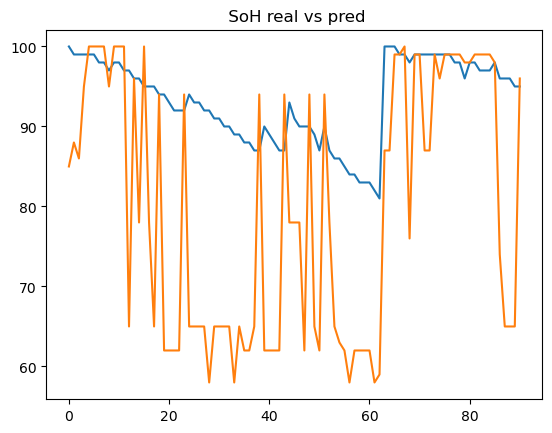

In [17]:
#KNeighborsTimeSeriesClassifier

padded_clf = PaddingTransformer() * KNeighborsTimeSeriesClassifier(n_neighbors=2, n_jobs=10)
padded_clf.fit(x_train, y_train)

y_pred = padded_clf.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()


0.07400422767497919
6.571428571428571
6.571428571428571


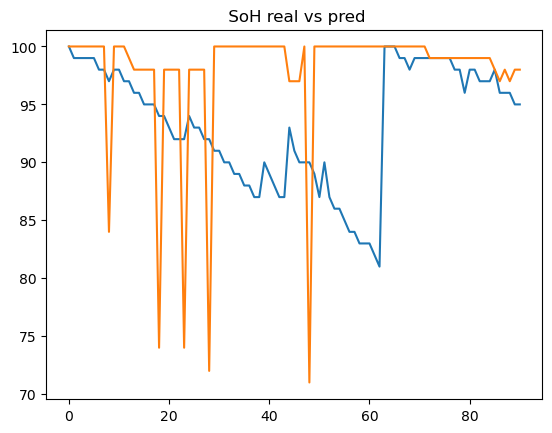

In [16]:
# random interval

#padded_clf = PaddingTransformer() * RandomIntervalClassifier(n_intervals=5)
padded_clf = PaddingTransformer() * RandomIntervalClassifier(n_intervals=10, random_state=1)

padded_clf.fit(x_train, y_train)

y_pred = padded_clf.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(np.mean(np.abs(y_test - y_pred)))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

0.013102107855141754
1.0617977528089888


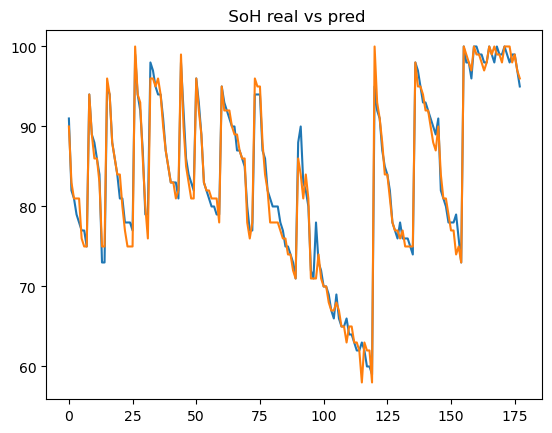

In [22]:

clf =  RocketClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.03632862729122225
3.1292134831460676


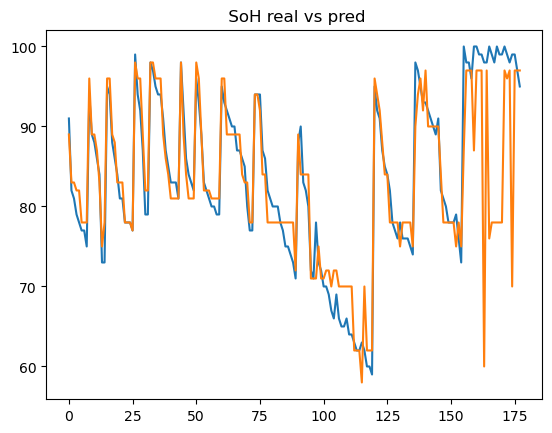

In [23]:
lstm = LSTMFCNClassifier(n_epochs=500,batch_size=16) 
lstm.fit(x_train, y_train)

y_pred = lstm.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

/home/apetrella/miniconda3/envs/battery_tsc/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
0.17571031779794205
14.764044943820224


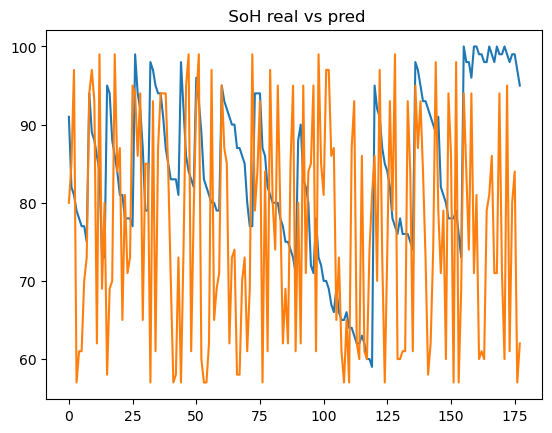

In [24]:
rnn = SimpleRNNClassifier(n_epochs=500,batch_size=16) 
rnn.fit(x_train, y_train)

y_pred = rnn.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.12228969119840441
9.432584269662922


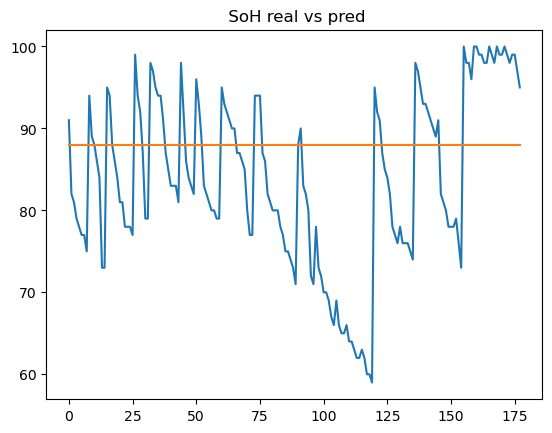

In [25]:
cnn = CNNClassifier(n_epochs=500,batch_size=16) 
cnn.fit(x_train, y_train)

y_pred = cnn.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()